In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [9]:
import sys
caffe_root = '../'
sys.path.insert(0, caffe_root+'/install/python/')

import caffe

In [10]:
import os
if os.path.isfile(caffe_root+'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [18]:
caffe.set_mode_cpu()

model_def = caffe_root+'/models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root+'/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,
                model_weights,
                caffe.TEST) # use test mode

In [19]:
mu = np.load(caffe_root+'/install/python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1) # mean (BGR)
print 'mean-substracted values:', zip('BGR', mu)

transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
print net.blobs['data'].data.shape

transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))

print net.blobs['data'].data.shape

mean-substracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
(10, 3, 227, 227)
(10, 3, 227, 227)


In [25]:
net.blobs['data'].reshape(50,  # reshape the batch size
                         3,
                         227,
                         227)

print net.blobs['data'].data.shape

(50, 3, 227, 227)


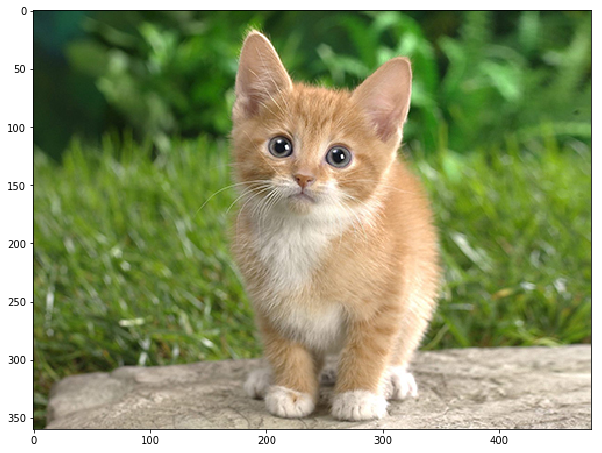

In [27]:
image = caffe.io.load_image(caffe_root+'/examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [15]:
net.blobs['data'].data[...] = transformed_image

output = net.forward()
output_prob = output['prob'][0]
print 'predicted class is: ', output_prob.argmax()

predicted class is:  281


In [16]:
labels_file = caffe_root+'/data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
else:
    print "Labels file found."

labels = np.loadtxt(labels_file, str, delimiter='\t')
print 'output label:', labels[output_prob.argmax()]

Labels file found.
output label: n02123045 tabby, tabby cat


In [17]:
top_inds = output_prob.argsort()[::-1][:5]
print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.31244653, 'n02123045 tabby, tabby cat'),
 (0.23797032, 'n02123159 tiger cat'),
 (0.12387866, 'n02124075 Egyptian cat'),
 (0.10075202, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957221, 'n02127052 lynx, catamount')]

In [19]:
caffe.set_mode_cpu()
net.forward()
%timeit net.forward()

1 loop, best of 3: 2.4 s per loop


In [20]:
caffe.set_device(0)
caffe.set_mode_gpu()
net.forward()
%timeit net.forward()

10 loops, best of 3: 25 ms per loop


In [21]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


In [22]:
for layer_name, blob in zip(net.blobs.iterkeys(), net.blobs.itervalues()):
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


In [23]:
# (n, channel, height, weight)
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


In [24]:
def vis_square(data):
    data = (data-data.min()) / (data.max()-data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n**2-data.shape[0]),
                  (0, 1), (0, 1))
                + ((0,0),) * (data.ndim-3))
    
    data = np.pad(data, padding, mode='constant', constant_values=1)

    # print data.reshape((n, n) + data.shape[1:]).shape
    # print data.reshape((n, n) + data.shape[1:]).transpose(0, 2, 1, 3, 4).shape
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    print data.shape
    plt.imshow(data)
    plt.axis('off')
    

(96, 3, 11, 11)
(96, 11, 11, 3)
(120, 120, 3)


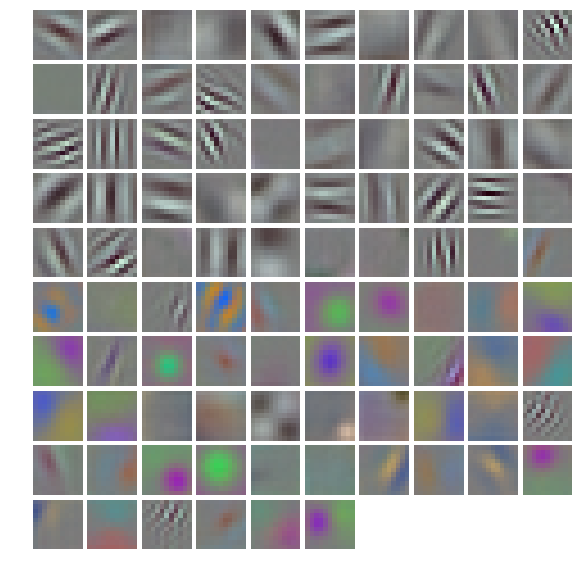

In [25]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
print filters.shape
print filters.transpose(0, 2, 3, 1).shape
vis_square(filters.transpose(0, 2, 3, 1))

(560, 560)


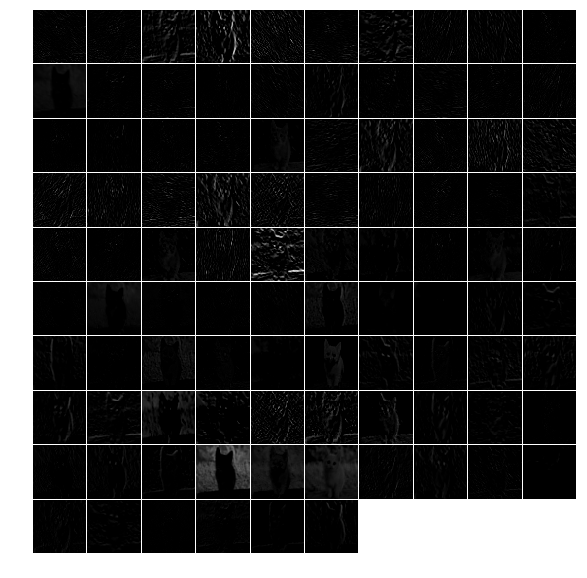

In [26]:
feat = net.blobs['conv1'].data[0, :96]
vis_square(feat)

(112, 112)


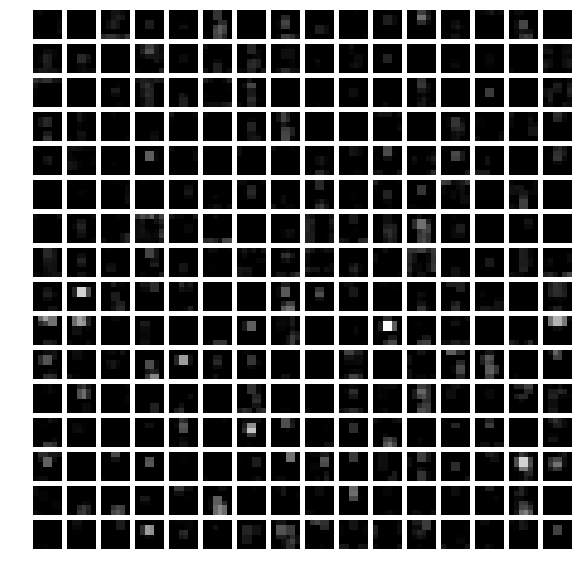

In [27]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

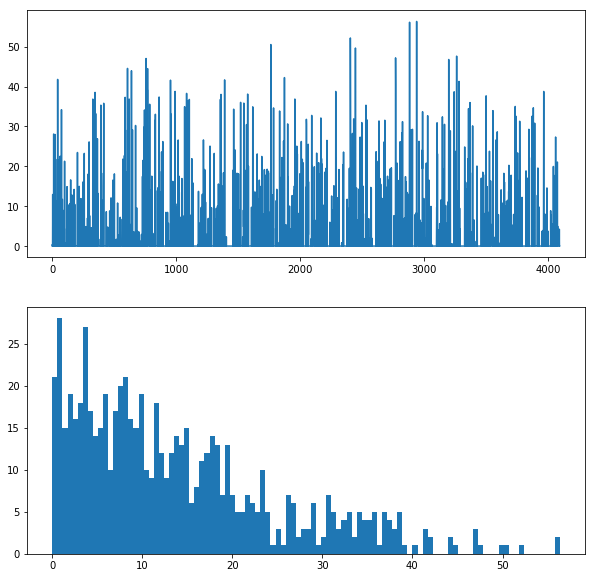

In [28]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat>0], bins=100)

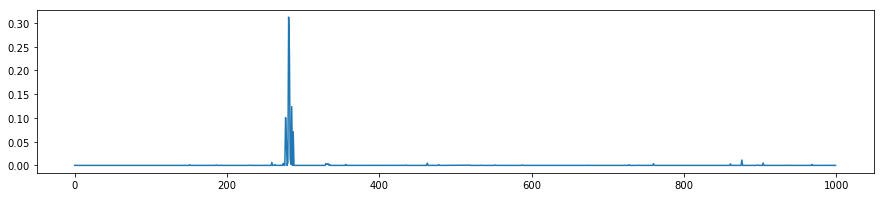

In [29]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

probabilities and labels:


[(0.27718785, 'n01692333 Gila monster, Heloderma suspectum'),
 (0.19859757,
  'n01753488 horned viper, cerastes, sand viper, horned asp, Cerastes cornutus'),
 (0.1142626, 'n01756291 sidewinder, horned rattlesnake, Crotalus cerastes'),
 (0.047695238, 'n02317335 starfish, sea star'),
 (0.031119877, 'n02137549 mongoose')]

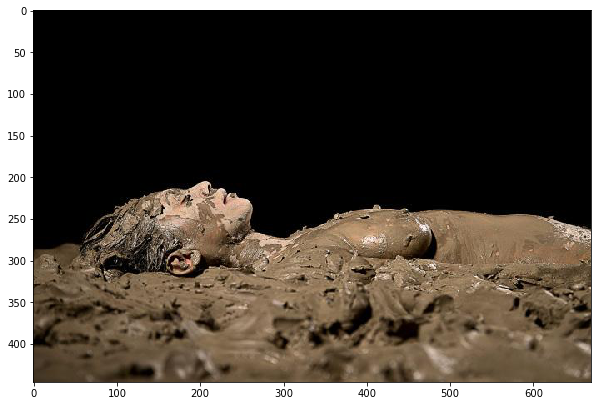

In [30]:
my_image_url = "https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1504941793&di=f515450d312859d0f9f5ea4ab6d260ac&imgtype=jpg&er=1&src=http%3A%2F%2Fpic.58pic.com%2F58pic%2F16%2F63%2F61%2F48U58PICsky_1024.jpg"
!wget -O image.jpg $my_image_url

image = caffe.io.load_image('human1.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])